Reading & Splitting Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

run_df = pd.read_csv("Data/run_df.csv")
pass_df = pd.read_csv("Data/pass_df.csv")

teams_features = [
    'posteam_ATL', 'posteam_BAL', 'posteam_BUF', 'posteam_CAR', 'posteam_CHI', 'posteam_CIN', 'posteam_CLE', 'posteam_DAL', 'posteam_DEN', 'posteam_DET', 'posteam_GB', 
    'posteam_HOU', 'posteam_IND', 'posteam_JAX', 'posteam_KC', 'posteam_LA', 'posteam_LAC', 'posteam_LV', 'posteam_MIA', 'posteam_MIN', 'posteam_NE', 'posteam_NO', 
    'posteam_NYG', 'posteam_NYJ', 'posteam_PHI', 'posteam_PIT', 'posteam_SEA', 'posteam_SF', 'posteam_TB', 'posteam_TEN', 'posteam_WAS', 'posteam_type_home',
    'defteam_ATL', 'defteam_BAL', 'defteam_BUF', 'defteam_CAR', 'defteam_CHI', 'defteam_CIN', 'defteam_CLE', 'defteam_DAL', 'defteam_DEN', 'defteam_DET', 'defteam_GB', 
    'defteam_HOU', 'defteam_IND', 'defteam_JAX', 'defteam_KC', 'defteam_LA', 'defteam_LAC', 'defteam_LV', 'defteam_MIA', 'defteam_MIN', 'defteam_NE', 'defteam_NO', 
    'defteam_NYG', 'defteam_NYJ', 'defteam_PHI', 'defteam_PIT', 'defteam_SEA', 'defteam_SF', 'defteam_TB', 'defteam_TEN', 'defteam_WAS'
    ]

# drop teams feature
run_df = run_df.drop(teams_features, axis=1)
pass_df = pass_df.drop(teams_features, axis=1)

# set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
fraction = 0.1

run_df_sampled = run_df.sample(frac=fraction, random_state=42)
pass_df_sampled = pass_df.sample(frac=fraction, random_state=42)

# Reset the index if needed
run_df_sampled = run_df_sampled.reset_index(drop=True)
pass_df_sampled = pass_df_sampled.reset_index(drop=True)

run_features = run_df_sampled.drop('yards_gained', axis=1)
run_target = run_df_sampled['yards_gained']

pass_features = pass_df_sampled.drop('yards_gained', axis=1)
pass_target = pass_df_sampled['yards_gained']

# Split the data into training and testing sets for runs and passes
run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target, test_size=0.2, random_state=42)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target, test_size=0.2, random_state=42)




Linear Regression

Run Model Mean Squared Error: 10.980785790980171
Pass Model Mean Squared Error: 17.044145035723798
Run Model Mean Absolute Error: 2.3764184548437552
Pass Model Mean Absolute Error: 3.1603733768187645
Run Model Root Mean Squared Error: 3.3137268733225693
Pass Model Root Mean Squared Error: 4.128455526673843


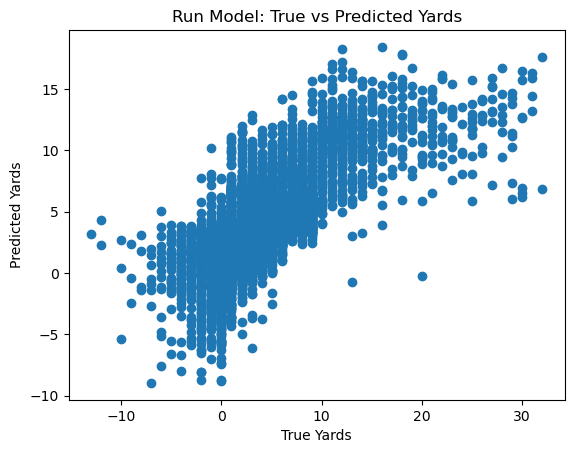

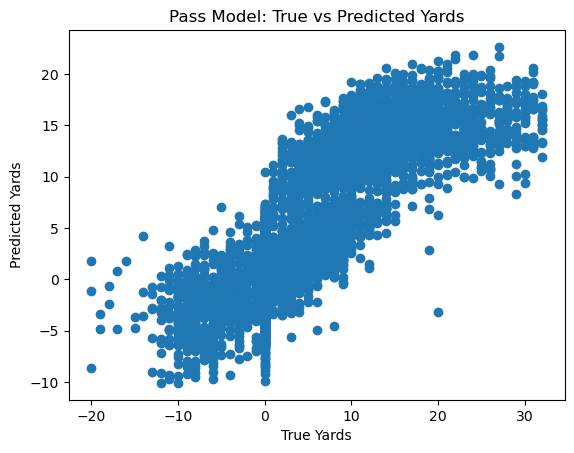

Run Model Cross-Validation Mean Squared Error: 10.864708342848004
Pass Model Cross-Validation Mean Squared Error: 16.843850440828795


In [2]:
run_model = LinearRegression()
run_model.fit(run_X_train, run_y_train)

pass_model = LinearRegression()
pass_model.fit(pass_X_train, pass_y_train)

# Make predictions on the test set
run_predictions = run_model.predict(run_X_test)
pass_predictions = pass_model.predict(pass_X_test)

# Evaluate the models
run_mse = mean_squared_error(run_y_test, run_predictions)
pass_mse = mean_squared_error(pass_y_test, pass_predictions)

run_rmse = mean_squared_error(run_y_test, run_predictions, squared = False)
pass_rmse = mean_squared_error(pass_y_test, pass_predictions, squared = False)

run_msa = mean_absolute_error(run_y_test, run_predictions)
pass_msa = mean_absolute_error(pass_y_test, pass_predictions)

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")
print(f"Run Model Mean Absolute Error: {run_msa}")
print(f"Pass Model Mean Absolute Error: {pass_msa}")
print(f"Run Model Root Mean Squared Error: {run_rmse}")
print(f"Pass Model Root Mean Squared Error: {pass_rmse}")


# Visualize predictions for runs
plt.scatter(run_y_test, run_predictions)
plt.title('Run Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Visualize predictions for passes
plt.scatter(pass_y_test, pass_predictions)
plt.title('Pass Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Cross-validation for runs
run_cv_scores = cross_val_score(run_model, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

# Cross-validation for passes
pass_cv_scores = cross_val_score(pass_model, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Polynomial Regression

Run Model Mean Squared Error: 8.080809145805867
Pass Model Mean Squared Error: 13.235212622132206


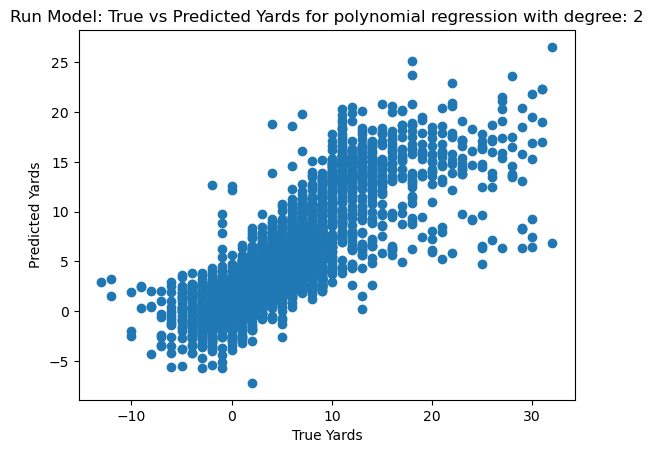

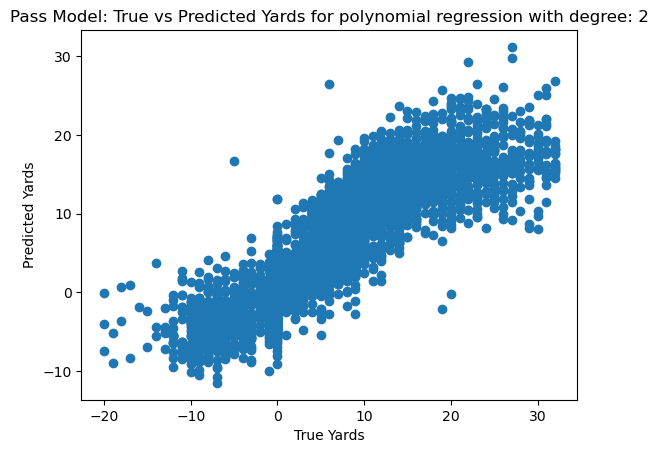

Run Model Mean Squared Error: 10.65215395413444
Pass Model Mean Squared Error: 18.66151120075441


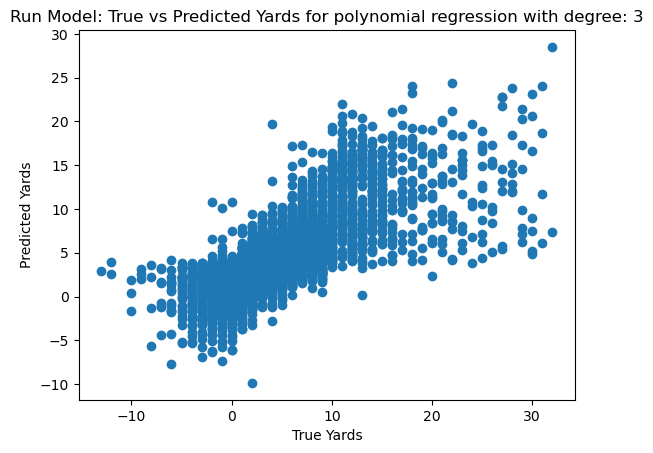

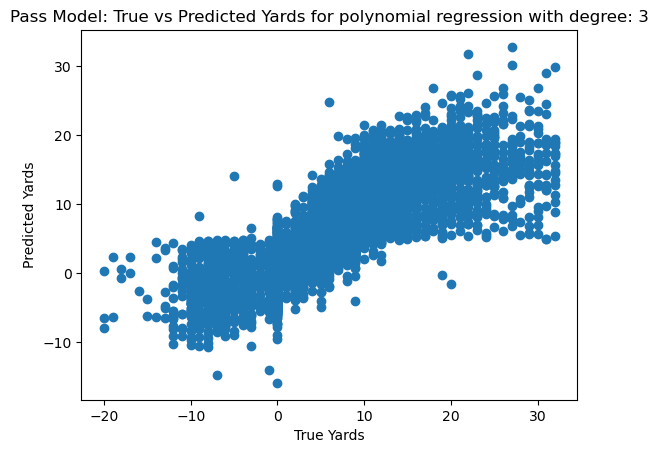

Run Model Mean Squared Error: 13.239422668957161
Pass Model Mean Squared Error: 199.9254452392752


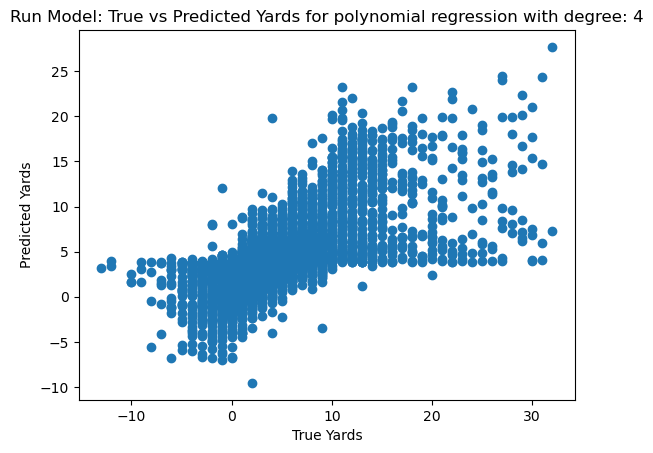

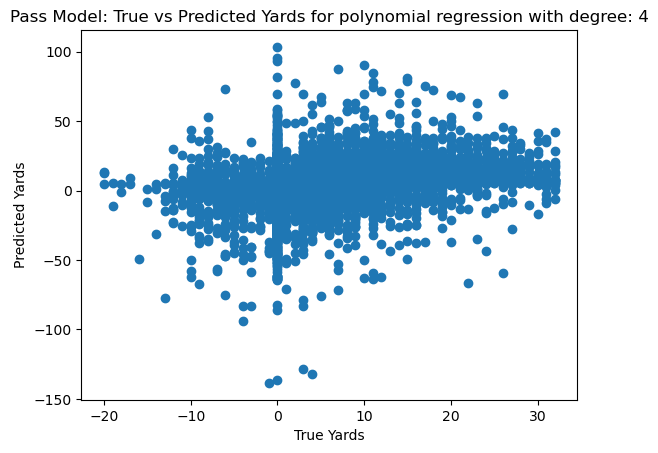

In [2]:
for degree in [2, 3, 4, 5]:
    run_poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    run_poly_model.fit(run_X_train, run_y_train)
    run_predictions = run_poly_model.predict(run_X_test)

    pass_poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    pass_poly_model.fit(pass_X_train, pass_y_train)
    pass_predictions = pass_poly_model.predict(pass_X_test)

    # Evaluate the models
    run_mse = mean_squared_error(run_y_test, run_predictions)
    pass_mse = mean_squared_error(pass_y_test, pass_predictions)

    print(f"Run Model Mean Squared Error: {run_mse}")
    print(f"Pass Model Mean Squared Error: {pass_mse}")

    # Visualize predictions for runs
    plt.scatter(run_y_test, run_predictions)
    plt.title('Run Model: True vs Predicted Yards for polynomial regression with degree: ' + str(degree))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    # Visualize predictions for passes
    plt.scatter(pass_y_test, pass_predictions)
    plt.title('Pass Model: True vs Predicted Yards for polynomial regression with degree: ' + str(degree))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()


KNN

       Unnamed: 0  score_differential  yardline_100  game_seconds_remaining  \
34385      345440            0.416096      0.418367                0.770833   
626        631658           -0.147979      0.234694                0.079722   
39636       11042            0.792147      0.265306                0.520556   
29111      616547           -0.524030      0.785714                0.934167   
41064       88441            0.792147      0.214286                0.511111   
...           ...                 ...           ...                     ...   
6265        26092            0.134058      0.479592                0.748056   
11284      279005            1.732273      0.622449                0.230000   
38158      747652            1.450235      0.357143                0.522222   
860        372029           -0.900080      0.112245                0.003889   
15795      119418           -1.464156      0.663265                0.365000   

           down   ydstogo   td_prob       wpa  roof

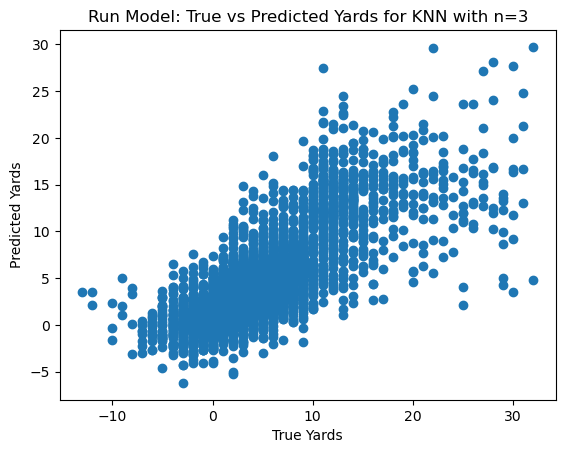

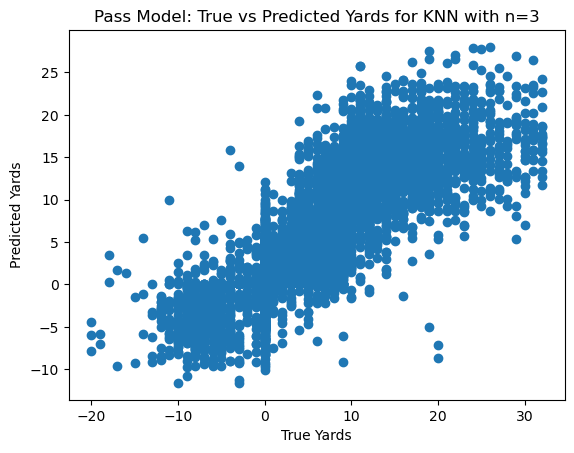

Run Model Mean Squared Error: 9.418775007466415
Pass Model Mean Squared Error: 16.24928097946871


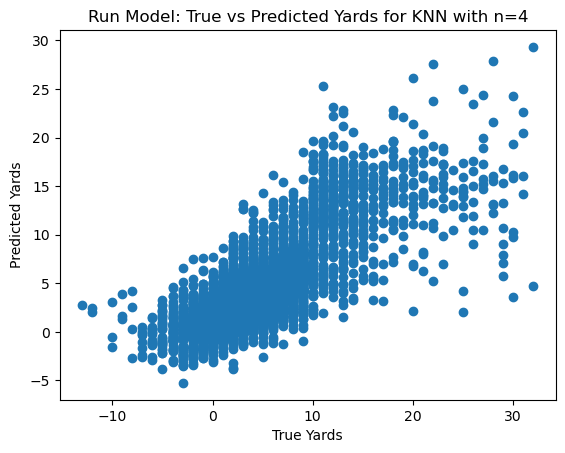

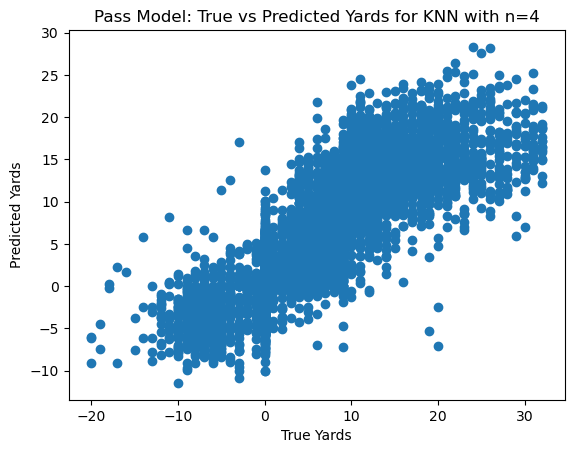

Run Model Mean Squared Error: 9.162214059938512
Pass Model Mean Squared Error: 15.783502335838781


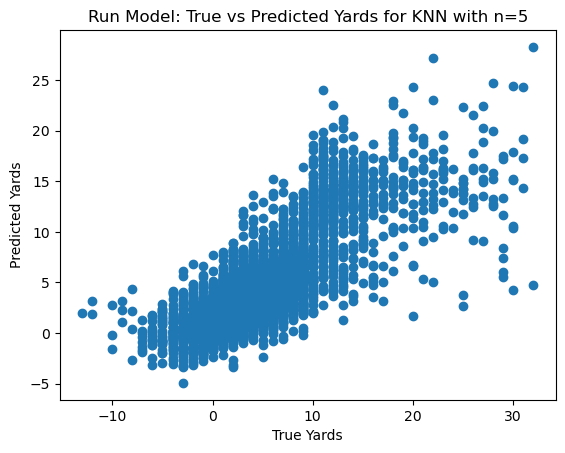

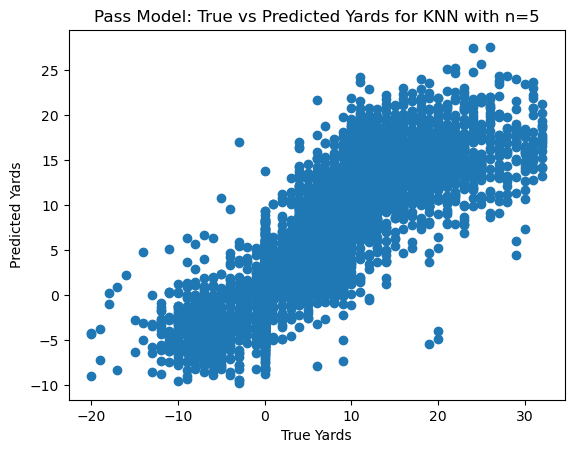

Run Model Mean Squared Error: 9.017585390683037
Pass Model Mean Squared Error: 15.487050837853799


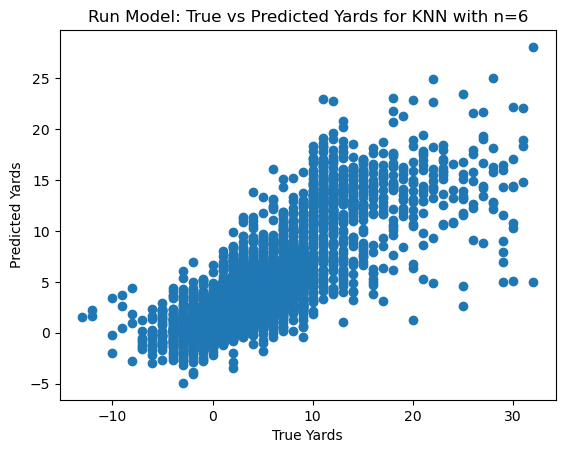

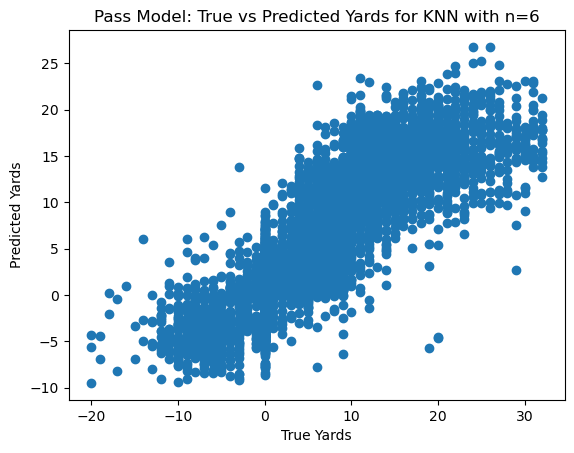

Run Model Mean Squared Error: 8.925080335943266
Pass Model Mean Squared Error: 15.22857443560883


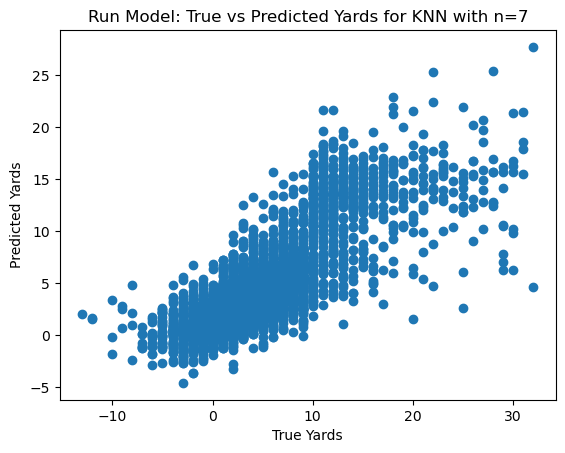

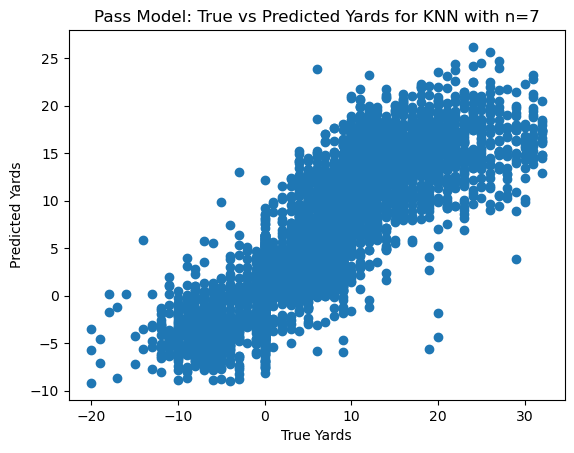

Run Model Mean Squared Error: 8.872613656346656
Pass Model Mean Squared Error: 15.193148642572321


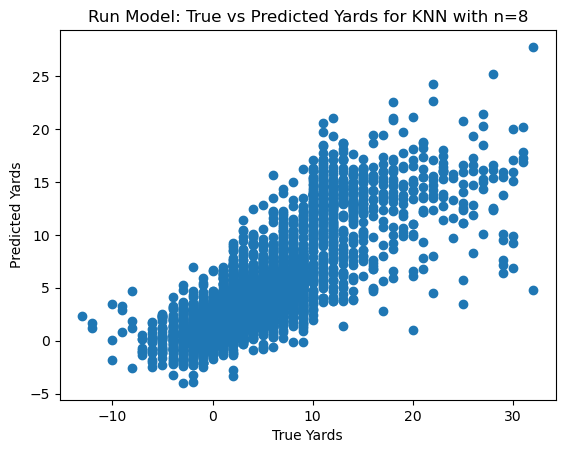

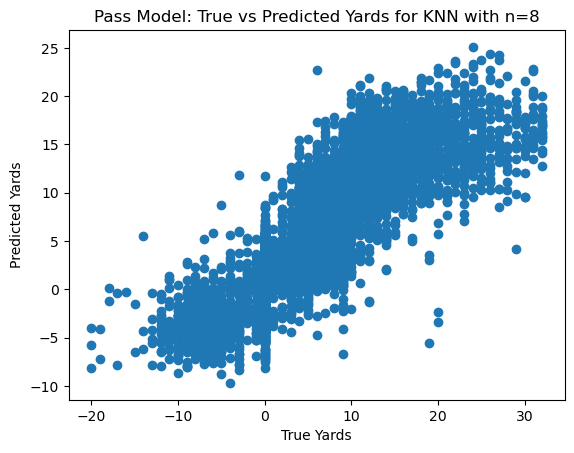

Run Model Mean Squared Error: 8.83291795833505
Pass Model Mean Squared Error: 15.076601990416183


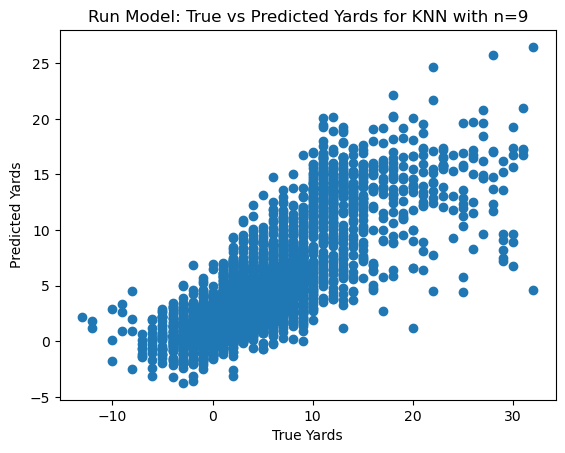

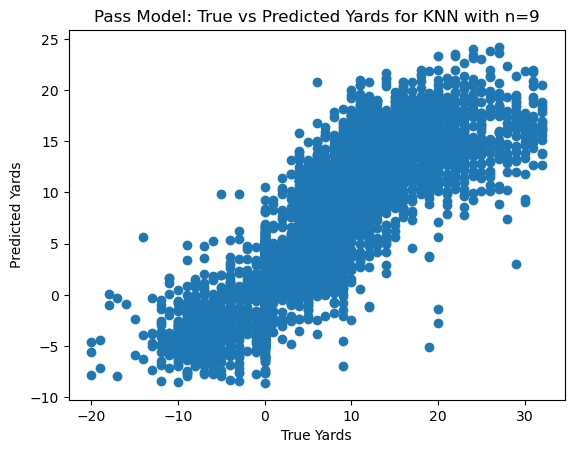

Run Model Mean Squared Error: 8.833537963355298
Pass Model Mean Squared Error: 15.020034437369555


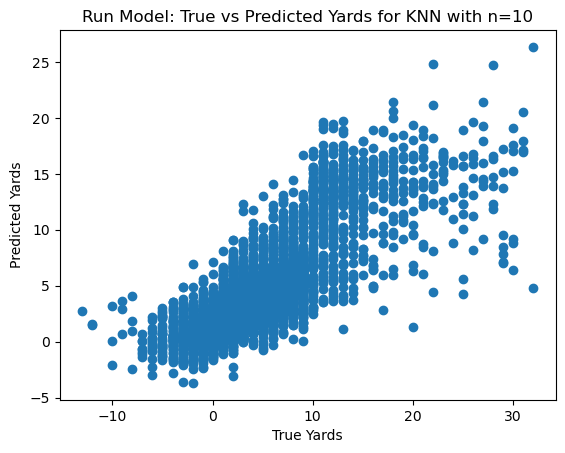

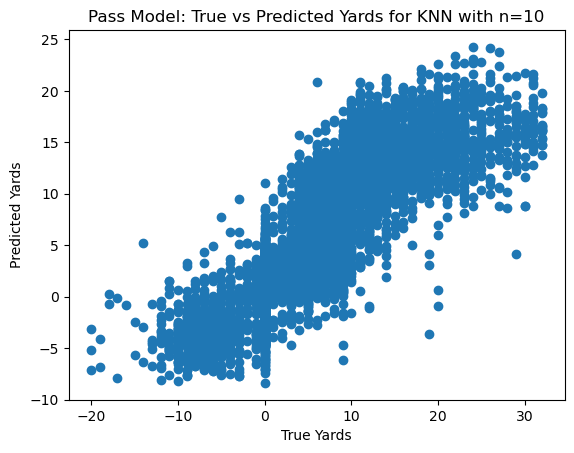

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for KNN)
scaler_run = StandardScaler()
X_run_train_scaled = scaler_run.fit_transform(run_X_train)
X_run_test_scaled = scaler_run.transform(run_X_test)

scaler_pass = StandardScaler()
X_pass_train_scaled = scaler_pass.fit_transform(pass_X_train)
X_pass_test_scaled = scaler_pass.transform(pass_X_test)

for n_neighbors in [3, 4, 5, 6, 7, 8, 9, 10]:

    # Initialize the KNN regressor
    pass_knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
    run_knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')

    # Train the model
    pass_knn_regressor.fit(X_run_train_scaled, pass_y_train)
    run_knn_regressor.fit(X_pass_train_scaled, run_y_train)

    # Make predictions on the test set
    pass_predictions = pass_knn_regressor.predict(X_pass_test_scaled)
    run_predictions = run_knn_regressor.predict(X_run_test_scaled)

    # Evaluate the model
    run_mse = mean_squared_error(run_y_test, run_predictions)
    pass_mse = mean_squared_error(pass_y_test, pass_predictions)

    print(f"Run Model Mean Squared Error: {run_mse}")
    print(f"Pass Model Mean Squared Error: {pass_mse}")

    # Visualize predictions for runs
    plt.scatter(run_y_test, run_predictions)
    plt.title('Run Model: True vs Predicted Yards for KNN with n=' + str(n_neighbors) )
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    # Visualize predictions for passes
    plt.scatter(pass_y_test, pass_predictions)
    plt.title('Pass Model: True vs Predicted Yards for KNN with n=' + str(n_neighbors))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

Random Forest

Run Model Mean Squared Error: 6.498229363608841
Pass Model Mean Squared Error: 9.888459567888308


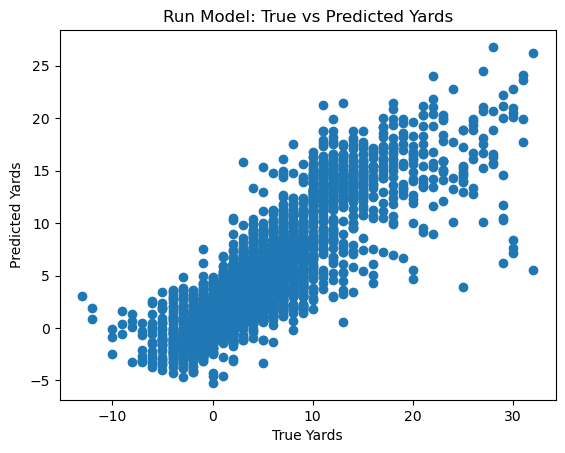

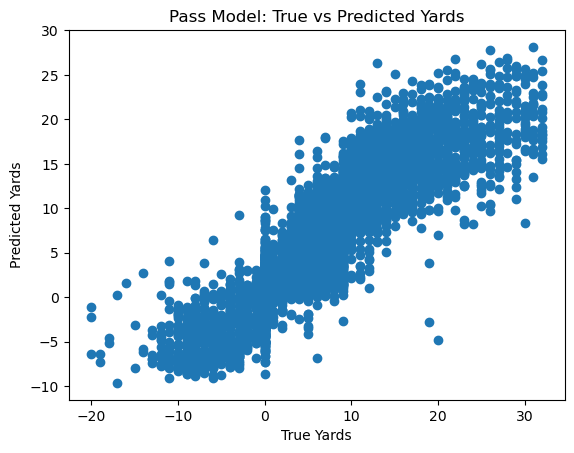

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
pass_knn_regressor = RandomForestRegressor(n_estimators=1000, random_state=42) 
run_knn_regressor = RandomForestRegressor(n_estimators=1000, random_state=42) 

# Train the model
pass_knn_regressor.fit(pass_X_train, pass_y_train)
run_knn_regressor.fit(run_X_train, run_y_train)

# Make predictions on the test set
pass_predictions = pass_knn_regressor.predict(pass_X_test)
run_predictions = run_knn_regressor.predict(run_X_test)

# Evaluate the model
run_mse = mean_squared_error(run_y_test, run_predictions)
pass_mse = mean_squared_error(pass_y_test, pass_predictions)

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")

# Visualize predictions for runs
plt.scatter(run_y_test, run_predictions)
plt.title('Run Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Visualize predictions for passes
plt.scatter(pass_y_test, pass_predictions)
plt.title('Pass Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Cross-validation for runs
# run_cv_scores = cross_val_score(run_knn_regressor, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
# print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

# Cross-validation for passes
# pass_cv_scores = cross_val_score(pass_knn_regressor, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
# print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Artificial Neuronal Network

Epoch 1/70
826/826 [==============================] - 1s 542us/step - loss: 13.2432 - val_loss: 8.7827
Epoch 2/70
826/826 [==============================] - 0s 480us/step - loss: 8.8351 - val_loss: 8.3529
Epoch 3/70
826/826 [==============================] - 0s 473us/step - loss: 8.4414 - val_loss: 8.1921
Epoch 4/70
826/826 [==============================] - 0s 477us/step - loss: 8.2821 - val_loss: 8.0591
Epoch 5/70
826/826 [==============================] - 0s 474us/step - loss: 8.1578 - val_loss: 8.0189
Epoch 6/70
826/826 [==============================] - 0s 509us/step - loss: 8.0441 - val_loss: 7.9057
Epoch 7/70
826/826 [==============================] - 0s 473us/step - loss: 7.9608 - val_loss: 7.8588
Epoch 8/70
826/826 [==============================] - 0s 497us/step - loss: 7.9265 - val_loss: 7.8970
Epoch 9/70
826/826 [==============================] - 0s 467us/step - loss: 7.9470 - val_loss: 7.8503
Epoch 10/70
826/826 [==============================] - 0s 495us/step - loss: 7.84

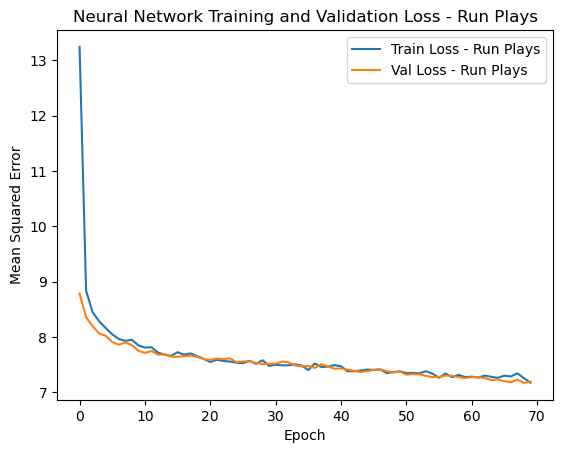

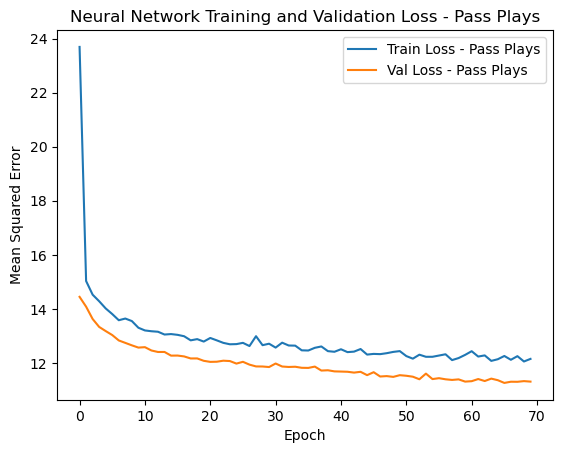

207/207 [==============================] - 0s 285us/step
Mean Squared Error (MSE) for run plays: 7.188719425688466
269/269 [==============================] - 0s 277us/step
Mean Squared Error (MSE) for pass plays: 11.3128712794226


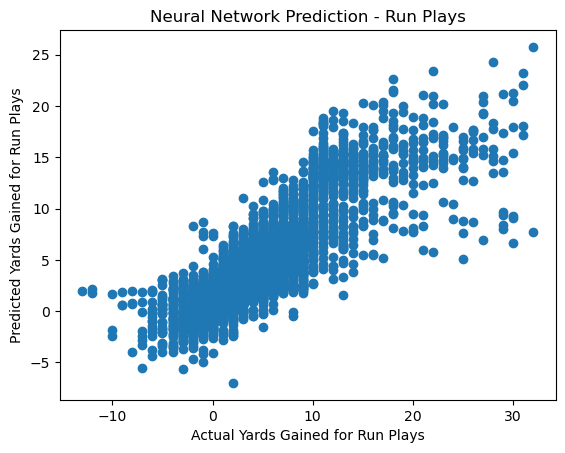

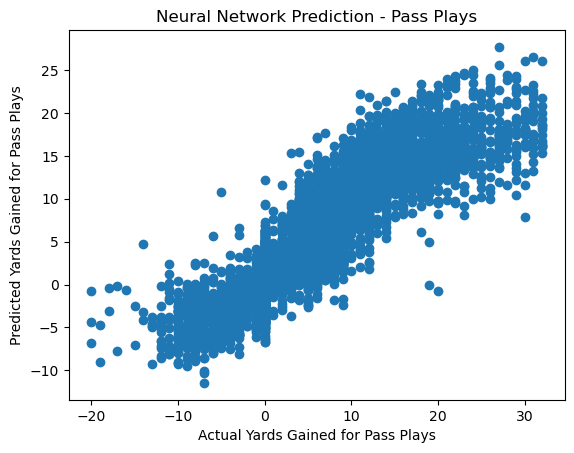

In [24]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

# Standardize the features
scaler_run = StandardScaler()
X_run_train_scaled = scaler_run.fit_transform(run_X_train)
X_run_test_scaled = scaler_run.transform(run_X_test)

scaler_pass = StandardScaler()
X_pass_train_scaled = scaler_pass.fit_transform(pass_X_train)
X_pass_test_scaled = scaler_pass.transform(pass_X_test)

# Build and train the neural network for run plays
model_run = Sequential()
model_run.add(Dense(64, input_dim=X_run_train_scaled.shape[1], activation='relu'))
# model_run.add(Dense(32, activation='relu'))
model_run.add(Dropout(0.2))
model_run.add(Dense(1, activation='linear'))

model_run.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history_run = model_run.fit(X_run_train_scaled, run_y_train, epochs=70, batch_size=32, validation_data=(X_run_test_scaled, run_y_test))

# Build and train the neural network for pass plays
model_pass = Sequential()
model_pass.add(Dense(64, input_dim=X_pass_train_scaled.shape[1], activation='relu'))
# model_pass.add(Dense(32, activation='relu'))
model_pass.add(Dropout(0.1))
model_pass.add(Dense(1, activation='linear'))

model_pass.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history_pass = model_pass.fit(X_pass_train_scaled, pass_y_train, epochs=70, batch_size=32, validation_data=(X_pass_test_scaled, pass_y_test))


# Plot the training and validation loss for run plays
plt.plot(history_run.history['loss'], label='Train Loss - Run Plays')
plt.plot(history_run.history['val_loss'], label='Val Loss - Run Plays')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network Training and Validation Loss - Run Plays')
plt.legend()
plt.show()

# Plot the training and validation loss for pass plays
plt.plot(history_pass.history['loss'], label='Train Loss - Pass Plays')
plt.plot(history_pass.history['val_loss'], label='Val Loss - Pass Plays')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network Training and Validation Loss - Pass Plays')
plt.legend()
plt.show()


# Evaluate the neural network for run plays
y_run_pred = model_run.predict(X_run_test_scaled)
mse_run = mean_squared_error(run_y_test, y_run_pred)
print(f"Mean Squared Error (MSE) for run plays: {mse_run}")

# Evaluate the neural network for pass plays
y_pass_pred = model_pass.predict(X_pass_test_scaled)
mse_pass = mean_squared_error(pass_y_test, y_pass_pred)
print(f"Mean Squared Error (MSE) for pass plays: {mse_pass}")

# Visualize predictions for run plays
plt.scatter(run_y_test, y_run_pred)
plt.xlabel('Actual Yards Gained for Run Plays')
plt.ylabel('Predicted Yards Gained for Run Plays')
plt.title('Neural Network Prediction - Run Plays')
plt.show()

# Visualize predictions for pass plays
plt.scatter(pass_y_test, y_pass_pred)
plt.xlabel('Actual Yards Gained for Pass Plays')
plt.ylabel('Predicted Yards Gained for Pass Plays')
plt.title('Neural Network Prediction - Pass Plays')
plt.show()
